# Anomaly Detection
This is an attempt to classify the scans into all the 4 classes.
Since the data distro is kind of skewed (we have nearly $10K$ images of normal which is equal to the total number of scans of all the other classes combined), so we'll treat the *COVID*, *Viral Pneumonia* and *Lung Opacity* as an anomaly. This will be the stage one of the pipeline which will be followed by a classification of the anomalous images into the respective 3 classes.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import h5py

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Add

import os
import shutil

print("Imports Complete")

Imports Complete


## Loading the data

In [2]:
#shutil.rmtree("/tmp/anomaly")

In [3]:
 !mkdir /tmp/anomaly

In [4]:
import glob
import shutil

def f2f(scr, dst='/tmp/anomaly'):
    for jf in glob.iglob(os.path.join(scr,"*.png")):
        shutil.copy(jf, dst)

In [5]:
"""

f2f(di+"COVID" )
f2f(di+'Lung_Opacity')
f2f(di+"Viral Pneumonia")
"""

'\n\nf2f(di+"COVID" )\nf2f(di+\'Lung_Opacity\')\nf2f(di+"Viral Pneumonia")\n'

In [6]:
!mkdir /tmp/normal

In [7]:
di = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/"
f2f(di+"Normal", "/tmp/normal")

Next we'll create a `dataset` of all the normal samples to train the *anomaly detection system*.

In [8]:
encotds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/normal", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "training", interpolation = "bicubic")

encovds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/normal", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "validation", interpolation = "bicubic")


Found 10192 files belonging to 1 classes.
Using 9173 files for training.


2022-02-21 20:39:54.995668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 20:39:55.106688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 20:39:55.107376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 20:39:55.110080: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 10192 files belonging to 1 classes.
Using 1019 files for validation.


Next, the dataset of all the anomalous samples.

In [9]:
"""
anoTds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "training", interpolation = "bicubic")

anoVds = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, 
    image_size = (224, 224), shuffle = True, seed = 42, 
    validation_split = 0.1, subset = "validation", interpolation = "bicubic")
"""

'\nanoTds = tf.keras.preprocessing.image_dataset_from_directory(\n    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, \n    image_size = (224, 224), shuffle = True, seed = 42, \n    validation_split = 0.1, subset = "training", interpolation = "bicubic")\n\nanoVds = tf.keras.preprocessing.image_dataset_from_directory(\n    "/tmp/anomaly", labels = None, color_mode = "rgb", batch_size = 32, \n    image_size = (224, 224), shuffle = True, seed = 42, \n    validation_split = 0.1, subset = "validation", interpolation = "bicubic")\n'

# The Model

In [10]:
def identity_block(X, f, filters, training=True):
    
    f1, f2, f3 = filters
    X_skip = X
    
    X = Conv2D(filters=f1, kernel_size=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2D(filters=f2, kernel_size=f, padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2D(filters=f3, kernel_size=1, padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    X = tf.keras.layers.Add()([X_skip, X])
    X = tf.keras.activations.relu(X)
    
    return X

In [11]:
def conv_block(X, f, filters, s=2, training=True):
    
    f1, f2, f3 = filters
    X_skip = X
    
    X = Conv2D(filters = f1, kernel_size = 1, strides = (s, s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2D(filters = f2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X) 
    
    X = Conv2D(filters = f3, kernel_size = 1, strides = (1, 1), padding='valid')(X)
    X = BatchNormalization()(X, training = training)
    
    X_skip = Conv2D(filters = f3, kernel_size = 1, strides=(s,s), padding='valid')(X_skip)
    X_skip = BatchNormalization()(X_skip, training = training)
    
    X = Add()([X, X_skip])
    X = tf.keras.activations.relu(X)
    
    return X

In [12]:
def Trans_conv_block(X, f, filters, s=2, training=True):
    
    f1, f2, f3 = filters
    X_skip = X
    
    X = Conv2DTranspose(filters = f1, kernel_size = 1, strides = (s, s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X)
    
    X = Conv2DTranspose(filters = f2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = tf.keras.activations.relu(X) 
    
    X = Conv2DTranspose(filters = f3, kernel_size = 1, strides = (1, 1), padding='same')(X)
    X = BatchNormalization()(X, training = training)
    
    X_skip = Conv2DTranspose(filters = f3, kernel_size = 1, strides=(s,s), padding='valid')(X_skip)
    X_skip = BatchNormalization()(X_skip, training = training)
    
    X = Add()([X, X_skip])
    X = tf.keras.activations.relu(X)
    
    return X

In [13]:
def enco(input_shape=(224,224,3)):
    
    X_inp = tf.keras.Input(shape=input_shape)
    
    X = Conv2D(64, (3,3), strides = (2,2))(X_inp)
    X = BatchNormalization(axis = 3)(X)
    X = tf.keras.activations.relu(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = conv_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    X = conv_block(X, 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    model = tf.keras.Model(inputs=X_inp,outputs=X)
    
    return model

In [14]:
mod = enco()
print(mod.output.shape)
mod.summary()

(None, 28, 28, 512)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 111, 111, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________

In [15]:
def deco(input_shape=(28,28,512)):
    
    X_inp = tf.keras.Input(shape=input_shape)
    
    X = Trans_conv_block(X_inp, 3, [256, 256, 128], s=2, training=True)
    X = identity_block(X, 3, [256, 128, 128])
    X = identity_block(X, 3, [256, 128, 128])
    
    X = Trans_conv_block(X, 3, [128, 64, 64], s=1, training=True)
    X = identity_block(X, 3, [128, 64, 64])
    X = identity_block(X, 3, [128, 64, 64])
    
    #X = Conv2DTranspose(64, (7,7), strides = (2,2), padding='valid')(X)
    X = Trans_conv_block(X, 3, [64, 32, 32], s=2, training=True)
    X = identity_block(X, 3, [64, 32, 32])
    X = identity_block(X, 3, [64, 32, 32])
    
    X = Trans_conv_block(X, 11, [64, 32, 32], s=2, training=True)
    X = Conv2D(filters=3 , kernel_size = 1, strides = 1, padding='valid')(X)
    
    model = tf.keras.Model(inputs=X_inp,outputs=X)
    
    return model   

In [16]:
mod = deco()
print(mod.output.shape)
mod.summary()

(None, 224, 224, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 512) 0                                            
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 56, 56, 256)  131328      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 56, 56, 256)  1024        conv2d_transpose[0][0]           
__________________________________________________________________________________________________
tf.nn.relu_19 (TFOpLambda)      (None, 56, 56, 256)  0           batch_normalization_21[0][0]     
________________________________________________________________________

In [17]:
class Autoencoder(tf.keras.Model):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = enco(input_shape=(224,224,3))
        self.decoder = deco(input_shape=(28,28,512)) 
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss = 'MeanSquaredError')

In [19]:
tds = encotds.map(lambda x : (x,x))
vds = encovds.map(lambda x : (x,x))

In [20]:
history = autoencoder.fit(tds,
                epochs=150,
                shuffle=True,
                validation_data=vds)

2022-02-21 20:40:00.818009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-02-21 20:40:07.293293: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


287/287 [==============================] - 147s 453ms/step - loss: 18690.2012 - val_loss: 16640.1094
Epoch 2/150
287/287 [==============================] - 125s 434ms/step - loss: 13086.0078 - val_loss: 9664.3398
Epoch 3/150
287/287 [==============================] - 125s 434ms/step - loss: 6164.9468 - val_loss: 3158.6021
Epoch 4/150
287/287 [==============================] - 125s 433ms/step - loss: 1502.6449 - val_loss: 558.3231
Epoch 5/150
287/287 [==============================] - 125s 434ms/step - loss: 222.6151 - val_loss: 94.1266
Epoch 6/150
287/287 [==============================] - 125s 434ms/step - loss: 60.4764 - val_loss: 51.2330
Epoch 7/150
287/287 [==============================] - 126s 434ms/step - loss: 46.1944 - val_loss: 40.5191
Epoch 8/150
287/287 [==============================] - 126s 435ms/step - loss: 41.0890 - val_loss: 36.7987
Epoch 9/150
287/287 [==============================] - 126s 437ms/step - loss: 37.2878 - val_loss: 34.5311
Epoch 10/150
287/287 [========

In [21]:
autoencoder.save("/savedModel")

2022-02-22 02:14:50.645952: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
new_model = tf.keras.models.load_model('/savedModel')

In [23]:
l = history.history.keys()
metrics = list(l)
df = pd.DataFrame(history.history)

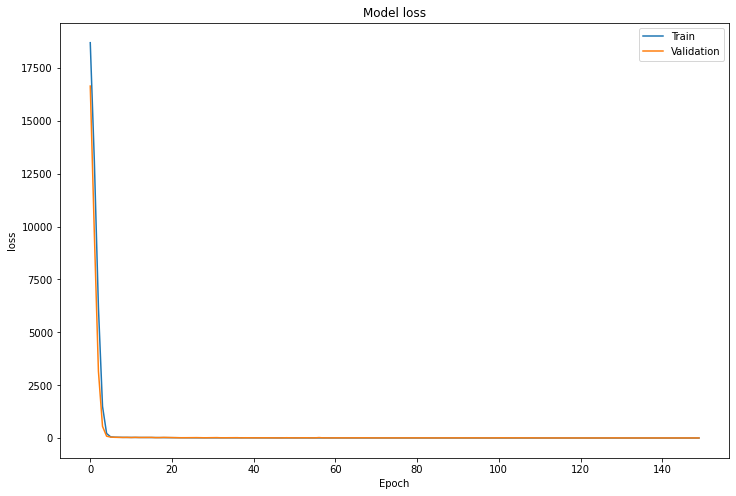

In [24]:
for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'Train',val:'Validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)


Let's try the model on a single example

In [25]:
img = cv2.imread("/tmp/normal/Normal-1.png", 1)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
img_list = []
img_list.append(np.array(img))
x = np.asarray(img_list)
recon = autoencoder.predict(x)

In [26]:
diff = recon - x
np.average(diff)

31.220528